# Generierung eigener Rhythmen basierend auf Datenanalyse von Schlagzeug Sequenzen durch Markov-Ketten 
### Generating unique rhythms based upon data analysis of drum loops by using Markov chains

Schlagzeug Sequenzen, sogenannte Drum-Loops, sind ein beliebtes Tool in der Musikindustrie: Interpreten können mithilfe dieser Loops selbst Demos erstellen oder ganze Stücke produzieren. Jedoch gestaltet sich die Auswahl als schwierig, wenn man kein versierter Schlagzeuger ist und kaum unterschiedlichen Stilistiken kennt. Das Ziel dieser Arbeit ist es dieses Problem zu lösen und die Auswahl von Schlagzeug Sequenzen zu vereinfachen. Es wird eine Datenbank aus Schlagzeug-Sequenzen erstellt und ein Programm welches diese Sequenzen verarbeitet und mithilfe von Markov-Ketten und des Viterbi-Algorithmus basierend auf der Datenbank künstliche Sequenzen generieren kann. Das [Essentia Framework](https://essentia.upf.edu/) dient hierbei als Grundlage.

Zu allererst importieren wir die benötigten Frameworks:

In [1]:
import markov_groove as mg
from pomegranate import DiscreteDistribution, HiddenMarkovModel
from pretty_midi import PrettyMIDI
import IPython
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pathlib import Path
sns.set(style="darkgrid")


%load_ext watermark
%watermark -m -n -p numpy,scipy,pomegranate,essentia,markov_groove

Wed Sep 09 2020 

numpy 1.18.2
scipy 1.5.2
pomegranate 0.13.4
essentia 2.1b6.dev184
markov_groove 0.1.0

compiler   : GCC 10.2.0
system     : Linux
release    : 5.8.3-2-MANJARO
machine    : x86_64
processor  : 
CPU cores  : 8
interpreter: 64bit


### Einlesen der Dateien

Nun lesen wir die Dateien ein und definieren unsere Parameter:

In [2]:
# Definiere Parameter:
disco = mg.util.read_audio_files("/home/jan_dev/loops/disco", "*/*.*")
techno = mg.util.read_audio_files("/home/jan_dev/loops/techno", "*/*.*")
ballad_mid = mg.util.read_midi_files("/home/jan_dev/loops/mid_loop/Ballads", "*.mid")
bpm = 125
beats = 8
steps = 128



disco_sequencers, disco_samples = mg.util.create_knowledge_base(
    disco, mg.OnsetAlgorithm.COMPLEX, beats, steps
)
techno_sequencers, techno_samples = mg.util.create_knowledge_base(
    techno, mg.OnsetAlgorithm.COMPLEX, beats, steps
)

ballad_sequencers = [mg.MidiSequencer.from_file(mid) for mid in ballad_mid]

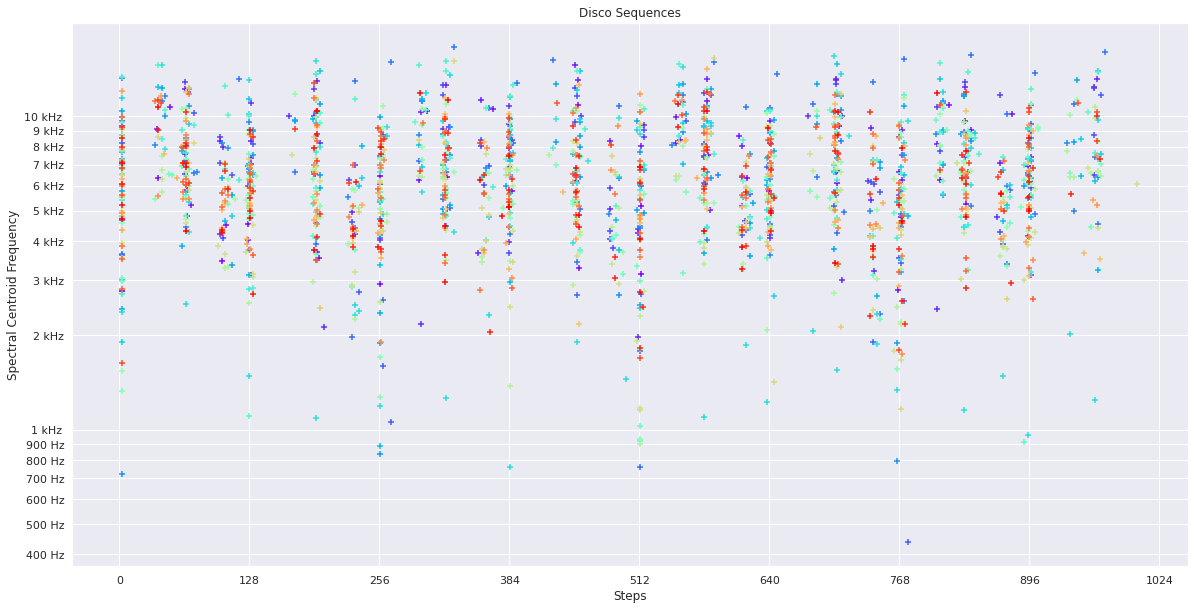

In [3]:
# Plot all disco sequences
colors = cm.rainbow(np.linspace(0, 1, len(disco_sequencers)))
_, ax = plt.subplots(figsize=(20, 10))
for sequencer, color in zip(disco_sequencers, colors):
    sequencer.visualize(ax, color)
plt.title("Disco Sequences")
plt.ylabel("Spectral Centroid Frequency")
plt.xlabel("Steps")
plt.show()
# print(f"Zeige {len(disco_sequencers)} Sequenzen. Insgesamt {len(disco_samples)} Samples.")

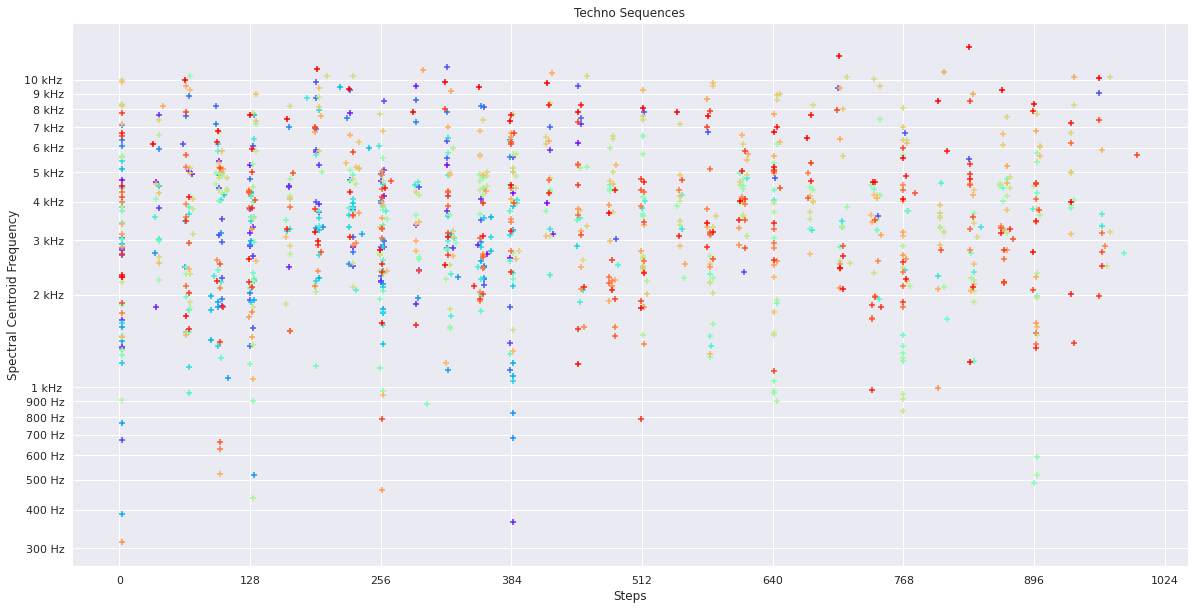

In [4]:
# Plot all techno sequences
colors = cm.rainbow(np.linspace(0, 1, len(techno_sequencers)))
_, ax = plt.subplots(figsize=(20, 10))
for sequencer, color in zip(techno_sequencers, colors):
    sequencer.visualize(ax, color)
plt.title("Techno Sequences")
plt.ylabel("Spectral Centroid Frequency")
plt.xlabel("Steps")
plt.show()
# print(f"Zeige {len(techno_sequencers)} Sequenzen. Insgesamt {len(techno_samples)} Samples.")

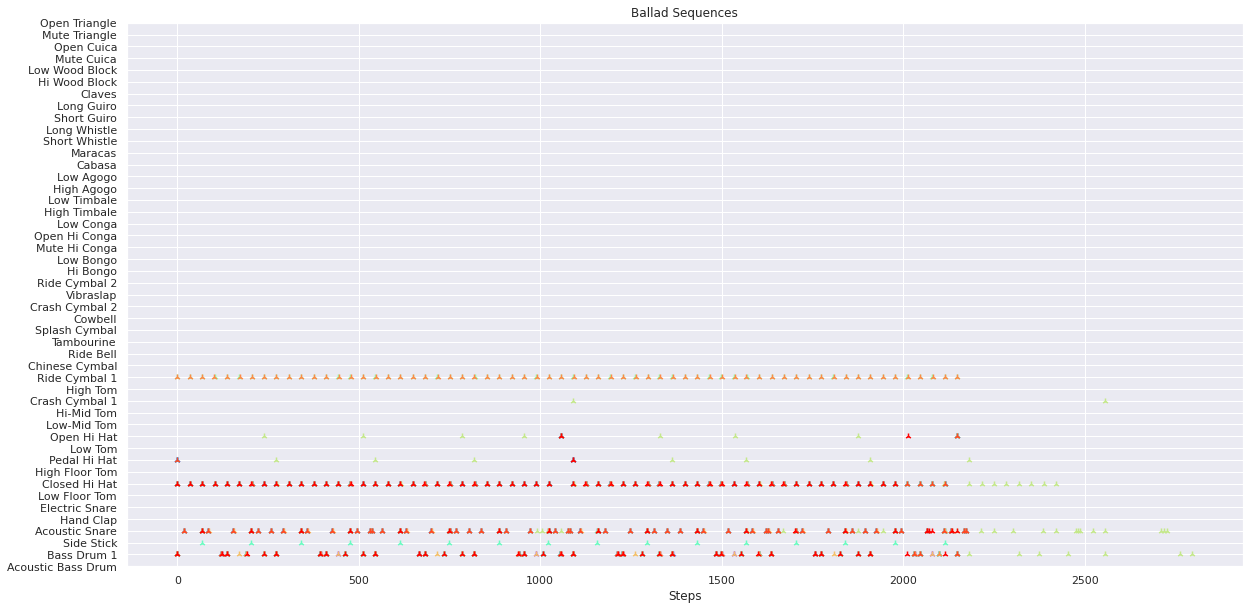

In [5]:
# Plot all ballad sequences
colors = cm.rainbow(np.linspace(0, 1, len(ballad_sequencers)))
_, ax = plt.subplots(figsize=(20, 10))
for sequencer, color in zip(ballad_sequencers, colors):
    sequencer.visualize(ax, color)
plt.title("Ballad Sequences")
plt.xlabel("Steps")
plt.yticks(range(35, 82))
plt.show()

Nun intialisieren das Generative Model:

In [7]:
disco_hidden_model = HiddenMarkovModel.from_samples(
    DiscreteDistribution,
    n_components=8,
    X=[seq.encode() for seq in disco_sequencers],
    name="disco",
    verbose=True,
)
techno_hidden_model = HiddenMarkovModel.from_samples(
    DiscreteDistribution,
    n_components=8,
    X=[seq.encode() for seq in techno_sequencers],
    name="techno",
    verbose=True,
)
ballad_hidden_model = HiddenMarkovModel.from_samples(
    DiscreteDistribution,
    n_components=8,
    X=[seq.encode() for seq in ballad_sequencers],
    name="ballad",
    verbose=True,
)

print("Alle Modelle wurden initialisiert und trainiert!")


.486781446961686e-07	Time (s): 0.07068
[5491] Improvement: 5.386900738812983e-07	Time (s): 0.07308
[5492] Improvement: 5.282909114612266e-07	Time (s): 0.07033
[5493] Improvement: 5.184792826185003e-07	Time (s): 0.07023
[5494] Improvement: 5.09580786456354e-07	Time (s): 0.07156
[5495] Improvement: 4.994890332454816e-07	Time (s): 0.07077
[5496] Improvement: 4.908924893243238e-07	Time (s): 0.07331
[5497] Improvement: 4.818975867237896e-07	Time (s): 0.07294
[5498] Improvement: 4.725243343273178e-07	Time (s): 0.07259
[5499] Improvement: 4.641551640816033e-07	Time (s): 0.08
[5500] Improvement: 4.555949999485165e-07	Time (s): 0.07319
[5501] Improvement: 4.4696935219690204e-07	Time (s): 0.07265
[5502] Improvement: 4.386856744531542e-07	Time (s): 0.07318
[5503] Improvement: 4.310932126827538e-07	Time (s): 0.07097
[5504] Improvement: 4.233188519719988e-07	Time (s): 0.07421
[5505] Improvement: 4.15015165344812e-07	Time (s): 0.0713
[5506] Improvement: 4.075791366631165e-07	Time (s): 0.07206
[5507]

In [8]:
# Genriere neue Sequenz mit HMM
disco_hidden_sequence = disco_hidden_model.sample(length=beats * steps+1)
techno_hidden_sequence = techno_hidden_model.sample(length=beats * steps+1)
ballad_hidden_sequence = ballad_hidden_model.sample(length=3000)
print("HMM Sequenzen wurden generiert!")

# Kreiere neue Sequencer
new_disco_seq =  mg.AudioSequencer.decode(disco_hidden_sequence, bpm, beats, steps)
new_disco_beat_samples = [disco_samples[freq] for _, freq in new_disco_seq.pattern if not np.isnan(freq)]

new_techno_seq =  mg.AudioSequencer.decode(techno_hidden_sequence, bpm, beats, steps)
new_techno_beat_samples = [techno_samples[freq] for _, freq in new_techno_seq.pattern if not np.isnan(freq)]

new_ballad_seq = mg.MidiSequencer.decode(ballad_hidden_sequence)

# Kreiere neue Schlagzeugsequenzen
disco_beat =  new_disco_seq.create_beat(samples=new_disco_beat_samples)
techno_beat =  new_techno_seq.create_beat(samples=new_techno_beat_samples)
ballad_beat = new_ballad_seq.create_beat()
print("Schlagzeugsequenzen erstellt!")

HMM Sequenzen wurden generiert!
Schlagzeugsequenzen erstellt!


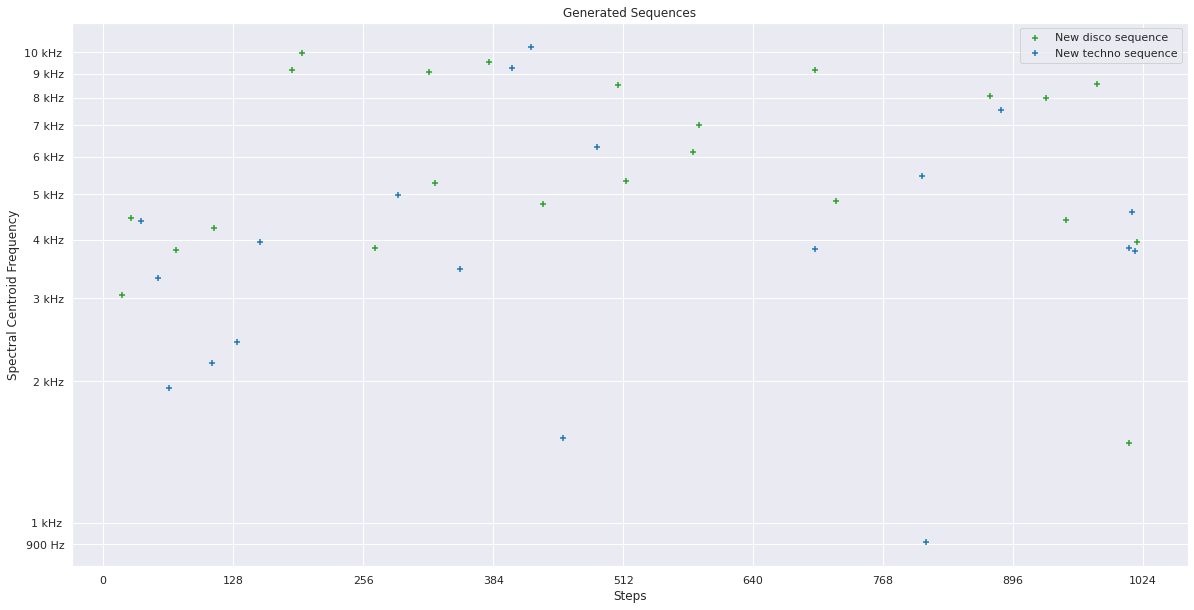

In [23]:
# Plot newly created sequences
_, ax = plt.subplots(figsize=(20, 10))
new_disco_seq.visualize(ax, "tab:green")
new_techno_seq.visualize(ax, "tab:blue")
ax.legend(["New disco sequence", "New techno sequence"])
plt.title("Generated Sequences")
plt.ylabel("Spectral Centroid Frequency")
plt.xlabel("Steps")
plt.show()

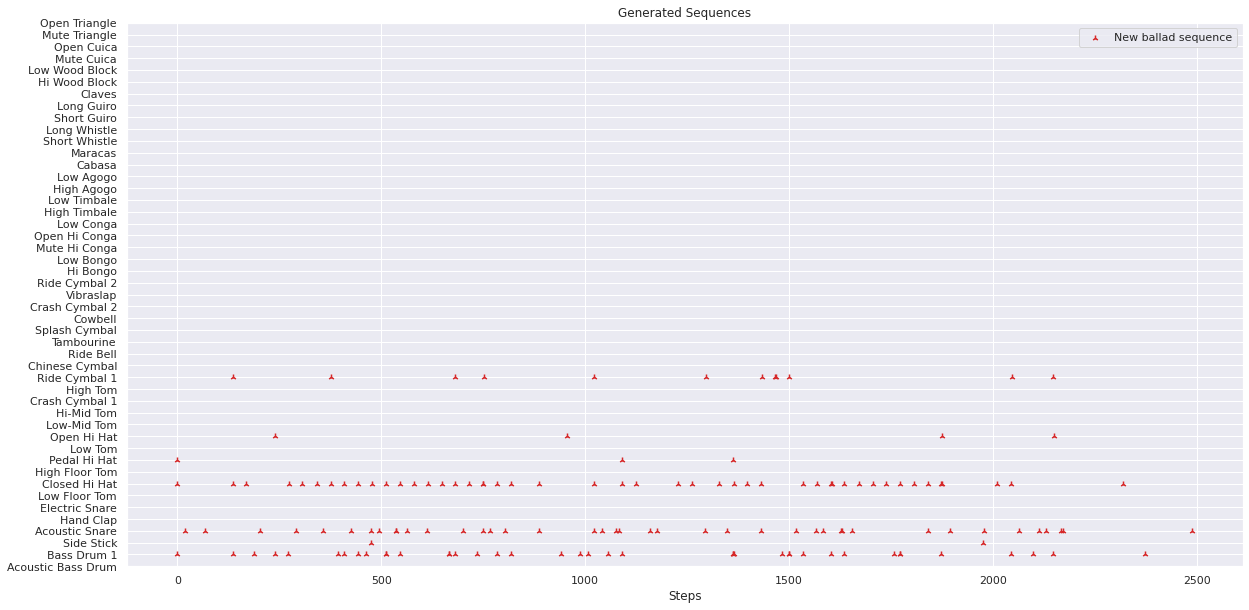

In [24]:
# Plot newly created sequences
_, ax = plt.subplots(figsize=(20, 10))
new_ballad_seq.visualize(ax, "tab:red")
ax.legend(["New ballad sequence"])
plt.title("Generated Sequences")
plt.xlabel("Steps")
plt.yticks(range(35, 82))
plt.show()

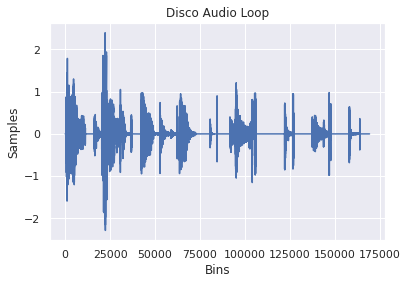

In [11]:
plt.plot(disco_beat.audio)
plt.title("Disco Audio Loop")
plt.ylabel("Samples")
plt.xlabel("Bins")
plt.show()

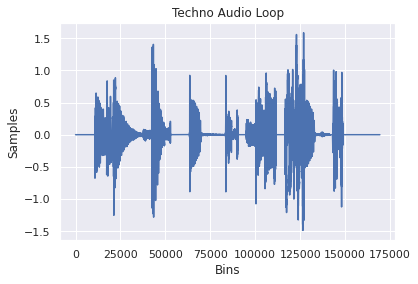

In [12]:
plt.plot(techno_beat.audio)
plt.title("Techno Audio Loop")
plt.ylabel("Samples")
plt.xlabel("Bins")
plt.show()

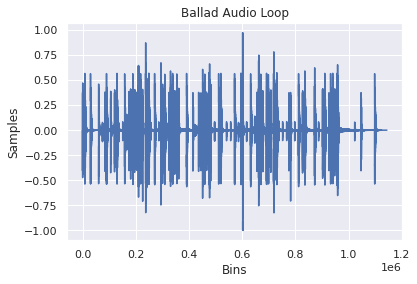

In [13]:
plt.plot(ballad_beat.audio)
plt.title("Ballad Audio Loop")
plt.ylabel("Samples")
plt.xlabel("Bins")
plt.show()

In [14]:
disco_beat.save(Path(".temp/disco_audio.wav"))
techno_beat.save(Path(".temp/techno_audio.wav"))
ballad_beat.save(Path(".temp/ballad_audio.wav"))
print("Dateien abgespeichert!")

Dateien abgespeichert!


In [18]:
disco_beat.display()

In [20]:
techno_beat.display()

In [25]:
ballad_beat.display()